# 1.0 Introduction

## [Styleformer: Transformer based Generative Adversarial Networks with Style Vector](https://arxiv.org/abs/2106.07023)

**Paper authors:** Jeeseung Park, Younggeun Kim

**Abstract:** "We propose *Styleformer*, a generator that synthesizes image using style vectors based on the Transformer structure" [...]

---

**Implemented by:**

Yusuf Soydan, yusuf.soydan@metu.edu.tr

Bartu Akyürek, bartu.akyurek@metu.edu.tr

## Contents
* [1.0 Introduction](#1_0)
    * [1.1 Summary](#1_1): Brief explanation of the paper
    * [1.2 Setting up the worksapce](#1_2): Workspace settings
    * [1.3 Disclaimer](#1_3): Scope of the implementation
    * [1.4 Dependencies](#1_4): Required libraries
* [2.0 Experiments](#2_0)
    * [2.1 Hyperparameters](#2_1): Training configuration 
    * [2.2 Dataset](#2_2): Dataset download & loading
    * [2.3 Model](#2_3): Model settings
    * [2.4 Experiment Start](#2_4): Training

* [3.0 DEMO-CIFAR10](#3_0)
    * [3.1 Loss Plot](#3_1): Training loss plot 
    * [3.2 Evaluation (CIFAR10)](#3_2): Dataset generation & & IS/FID scores

* [4.0 DEMO-STL10](#4_0)
    * [4.1 Loss Plot](#4_1): Training loss plot
    * [4.2 Evaluation (STL10)](#4_2): Dataset generation & IS/FID scores

* [5.0 Discussion](#5_0) 
    * [5.1 Assumptions](#5_1): Training configuration 
    * [5.2 Version 2 Updates](#5_2): Extended goals
    * [5.3 Final Scores](#5_3): Final scores with comparison





## 1.1 Summary <a id="1_1_Summary"></a>

In summary, this paper takes StyleGAN2 architecture, and replaces its encoder with a transformer encoder. The overall flow of the code is illustrated at Figure 2(a) in the paper. Figure 2(b) is the inside of each encoder block, that is utilizing style vectors within a self-attention mechanism.

The proposed model *Styleformer*, a generator that creates images by utilizing style vectors within the framework of the transformer structure. This paper introduces enhancements to the transformer structure, such as multi-head attention and pre-layer normalization. Additionally, the authors introduce a module called Attention Style Injection, which is a method for modulating and demodulating styles in the self-attention operation. These new components of the generator address the limitations of CNNs, enabling better handling of long-range dependencies and improved understanding of the global structure of objects.

Similar to the synthesis network of StyleGAN, the generator is conditioned on a learnable constant input. However, there is a distinction in how the constant input is handled in the approach. The constant input, initially an 8x8 matrix, is flattened to a size of 64 before being fed into the Transformer-based encoder. This flattened input, along with learnable positional encoding, undergoes processing in the Styleformer encoder. The Styleformer encoder is based on the Transformer encoder, but it incorporates several modifications to ensure efficient image generation, which will be elaborated on in the following sections. Once the input has passed through multiple encoder blocks, further steps in the process can be carried out.

###### StyleGAN Mapping
<img width="200" alt="stylegan_mapping" src="https://github.com/gcinbis/deep-generative-models-course-projects/assets/77360680/4ddd4852-9dcb-4c79-b207-882a9c998afb">

###### Styleformer
![model](https://github.com/gcinbis/deep-generative-models-course-projects/assets/77360680/4547cc8a-194b-4a31-865f-e38ec5ed43cf)

### Stleformer Components from Transformer (Modifications)

#### Multi-Head Attention
The authors obtain the optimal attention head number with respect to FID scores of 256 and 32 hidden dimensions as 32.

#### Pre-Layer Normalization
The layer normalization of the existing transformer structure comes after a linear layer that integrates multiheads. The paper hypothesis that the role of layer normalization is generating attention map and imposes it after the style modulation 

#### Modified Resudual Connection
Unlike transformers, the residual connection is not established between input and sublayer output, rather, it is done for scaled input. 

#### Eliminaing Feedforward Network
Unlike original transformer encoder, style encoder does not employ any feedforward network due to the better performance obtained in the ablation study.

### Attention Style Injection
In the StyleGAN, the input of the each layer is scaled with the style vector and normalized. This process is called adaptive instance normalization (AdaIN). However, this process causes artifacts on images generated and demodulation is introduced to alleviate the shortcommings of AdaIN. 

#### Modulation for Self-Attention
Just like StyleGAN, input feature map is scaled by style vector, whereas in Styleformer there is no convolution, rather it has dot product of query and key to create attention map and weighted sum of the value with attention map. The ablation study shows that the style vectors should be different for each modulation step.

The modulation is incorporated as follows,

$w_{i,j}^\prime = s_i . w_{i,j}$

where $w$ is the original weight to make (Q, K, V) from flattened input feature map, and $w_{i,j}^\prime$ is modulated linear weight. $s_i$ is the $i$th component of the style vector, $j$ is the dimension of weight.

#### Demodulation of Query, Key, and Value
Q, K, and V are created through linear operation to the input feature map scaled with *Style Input*, 
After that, V will be modulated with Style Value vector additionally. Since the modulation enlarges the values which prevents the attention operation working properly, the demodulation of Q, K, V is required for following steps. The demodulation is operated as scaling the each dimension $j$ of the weights with the standard deviation of the output $1/\sigma_j$ calculated as

$\sigma_j = \sqrt{\sum_i {w_{i,j}^\prime}^2}$


#### Demodulation for the Encoder Output
After demodulation of Q, K, and V, V is modulated with the other style vector, attention map and V is weighted summed, linear operation is performed for multi head integration. Since the output of those operations is the input for another encoder block, the demodulation operation is required. For the last demodulation operation (ecoder demod) the standard deviation can be calculated

$\sigma_{l,k}^\prime = \sqrt{\sum A_l^2 \sum_j {w_{j,k}^\prime}^2}$

$A$ is the attention map and calculated as in the original transformer and modulated linear weight $w_{j,k}^\prime = s_j . w_{j,k}$

Because of $\sigma_{l,k}^\prime$ normalizes each pixel as a unit and attention map is input dependent and demodulation operation with statistical assumptions can not be applied to it, the demodulation is performed by dividing $\sigma_{l,k}$ which is

$\sigma_{l,k} = \frac{\sigma_{l,k}^\prime}{\sigma_{k}^{\prime\prime}} = \sqrt{\sum A_l^2}$

where $\sigma_{k}^{\prime\prime} = \sqrt {\sum_j {w_{j,k}^\prime}^2}$

However, the demodulation with $\sigma_{l,k}$ yields outputs with standard deviation approaching to zero, Modified Residual is performed such that linear opeartion is performed to Mod Value followed by demodulation. This process yields unit standard deviation variables and they are added to the zero standard deviation outputs.

## 1.2 Setting up the workspace


Pretrained models "discriminator_cifar10.pth" and "generator_cifar10.pth" should be under "output/trained_model" folder. With this setup, you should be able to run the notebook smoothly. Note that you don't need to download the datasets, CIFAR10 and STL10 as it will be automatically downloaded with this notebook.


## 1.3 Disclaimer
The base code of this project is taken from [LABML's  StyleGAN2](https://nn.labml.ai/gan/stylegan/index.html) which is a simplified implementation of original [StyleGAN2-ADA](https://github.com/NVlabs/stylegan2-ada-pytorch). We have taken these repositories as a reference and built the Styleformer on top of LABML's StyleGAN2.


---



This choice is rooted from the Styleformer's paper, Page 6, Section 4:

*We only change the architecture of the generator in
StyleGAN2-ADA, i.e., synthesis network, while maintaining
the discriminator architecture and loss function*

## 1.4 Dependencies

In [ ]:
!pip install labml
!pip install labml_helpers
!pip install labml_nn

!pip install tqdm
!pip install matplotlib
!pip install scipy

In [ ]:
"""
Run from Colab or local
"""

import os

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    ROOT_PATH = "/content/gdrive/MyDrive/group03_version2"
    %cd ./gdrive/MyDrive/group03_version2/
except:
    ROOT_PATH = os.curdir

Mounted at /content/gdrive
/content/gdrive/MyDrive/group03_version2


In [ ]:
"""
Define path variables
"""
DATA_PATH = os.path.join(ROOT_PATH, "data")                                     # Path for the datasets
DATA_PATH_CIFAR = os.path.join(DATA_PATH, "cifar")                              # Path for CIFAR10 dataset
DATA_PATH_STL = os.path.join(DATA_PATH, "stl")                                  # Path for STL10 dataset

OUTPUT_PATH = os.path.join(ROOT_PATH, "output")                                 # Root path for the output of this notebook

LOSS_PATH = os.path.join(OUTPUT_PATH, "loss_plot")                              # Where we save loss plots
LOSS_PATH_CIFAR = os.path.join(LOSS_PATH, "cifar10")                            # Where we save loss plots
LOSS_PATH_STL = os.path.join(LOSS_PATH, "stl10")                                # Where we save loss plots

GENERATED_IMAGE_PATH = os.path.join(OUTPUT_PATH, "generated_images")            # Where we save checkpoint generated images
GENERATED_IMAGE_PATH_CIFAR = os.path.join(GENERATED_IMAGE_PATH, "cifar10")            
GENERATED_IMAGE_PATH_STL = os.path.join(GENERATED_IMAGE_PATH, "stl10")            

GEN_DATASET_SAVE_PATH = os.path.join(OUTPUT_PATH, "generated_dataset")          # Where we save generated dataset for FID/IS calculations
GEN_DATASET_SAVE_PATH_CIFAR = os.path.join(GEN_DATASET_SAVE_PATH, "cifar10")
GEN_DATASET_SAVE_PATH_STL = os.path.join(GEN_DATASET_SAVE_PATH, "stl10")

_PRETRAINED_MODELS_PATH = os.path.join(OUTPUT_PATH, "trained_model")
PRETRAINED_GEN_PATH = os.path.join(_PRETRAINED_MODELS_PATH, "generator_cifar10.pth")           # Cifar10 Pretrained model's path
PRETRAINED_GEN_PATH_STL = os.path.join(_PRETRAINED_MODELS_PATH, "generator_stl10.pth")         # STL-10 Pretrained model's path
PRETRAINED_DISC_PATH = os.path.join(_PRETRAINED_MODELS_PATH, "discriminator_cifar10.pth") 
PRETRAINED_DISC_PATH_STL = os.path.join(_PRETRAINED_MODELS_PATH, "discriminator_stl10.pth")

In [ ]:
"""
Create necessary directories
"""
# ------------------------------------------------
if not(os.path.isdir(DATA_PATH)):
  os.mkdir(DATA_PATH)

if not(os.path.isdir(DATA_PATH_CIFAR)):
  os.mkdir(DATA_PATH_CIFAR)

if not(os.path.isdir(DATA_PATH_STL)):
  os.mkdir(DATA_PATH_STL)
# ------------------------------------------------
if not(os.path.isdir(OUTPUT_PATH)):
  os.mkdir(OUTPUT_PATH)

if not(os.path.isdir(GENERATED_IMAGE_PATH)):
  os.mkdir(GENERATED_IMAGE_PATH)

if not(os.path.isdir(GENERATED_IMAGE_PATH_CIFAR)):
  os.mkdir(GENERATED_IMAGE_PATH_CIFAR)

if not(os.path.isdir(GENERATED_IMAGE_PATH_STL)):
  os.mkdir(GENERATED_IMAGE_PATH_STL)

if not(os.path.isdir(LOSS_PATH)):
  os.mkdir(LOSS_PATH)

if not(os.path.isdir(LOSS_PATH_CIFAR)):
  os.mkdir(LOSS_PATH_CIFAR)
  
if not(os.path.isdir(LOSS_PATH_STL)):
  os.mkdir(LOSS_PATH_STL)

if not(os.path.isdir(_PRETRAINED_MODELS_PATH)):
  os.mkdir(_PRETRAINED_MODELS_PATH)
# ------------------------------------------------
if not(os.path.isdir(GEN_DATASET_SAVE_PATH)):
  os.mkdir(GEN_DATASET_SAVE_PATH)

if not(os.path.isdir(GEN_DATASET_SAVE_PATH_CIFAR)):
  os.mkdir(GEN_DATASET_SAVE_PATH_CIFAR)

if not(os.path.isdir(GEN_DATASET_SAVE_PATH_STL)):
  os.mkdir(GEN_DATASET_SAVE_PATH_STL)

In [ ]:
# General Dependencies
import math
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Dependencies of LABML
from labml import experiment


In [ ]:
# Import this project's source files
from dataset import CIFAR10, STL10
from metrics import generateddataset, metrics
from models import generator, discriminator
from utils import utils, config

# 2.0 EXPERIMENTS

## 2.1 Hyperparameters

In [ ]:
# --------------------------------------------------------------------------------------------

dataset_name = "cifar"                   # Set it to "cifar" or "stl"

batch_size = 32                        # Batch size
image_size = 32                        # Image resoluiton, 32 for CIFAR
learning_rate = 1e-3                   # Learning rate
adam_betas = (0.0, 0.99)               # Adam optimization betas
is_style_mixing = False                # Set to False for CIFAR10, Styleformer Appendix.A
style_mixing_prob = 0.9                # Style mixing probability
    
h_dim_w = 256                          # Latent dimension
w_depth = 2                            # Depth
attn_depth = 32                        # Attention depth
num_enc_blocks = [1,2,2]               # See Styleformer Table 5 Layers {1, 3, 3}
enc_dims = [256,64,16]                 # See Styleformer Table 5 Hidden Size {1024,512,512}

channel_base = 2**11                   # Overall multiplier for the number of channels.              
channel_max = 512                      # Maximum number of channels in any layer.
last_resolution = 4                    # Resolution of the last layer
mbstd_group_size = 4                   # Group size for the minibatch standard deviation layer

training_steps = 20_000                # Originally it was 150_000 for LABML's StyleGAN2
starting_step = 176_000                # Starting step number, 0:from scratch; nonzero: load pretrained model (stl: 86_000, cifar: 176_000)
log_generated_interval = 1_000         # Number of steps to generate intermediate results (1_000 or 2_000 can be used for training)
save_checkpoint_interval = 2_000       # Number of steps to save a checkpoint for generator and discriminator (2_000 can be used for training)
                                      
# --------------------------------------------------------------------------------------------

## 2.2 Dataset

In [ ]:
pretrained_generator_path = PRETRAINED_GEN_PATH
pretrained_discriminator_path = PRETRAINED_DISC_PATH
generated_im_path = GENERATED_IMAGE_PATH_CIFAR
loss_plot_path = LOSS_PATH_CIFAR

# Load CIFAR-10
if dataset_name == "cifar":
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = CIFAR10(root=DATA_PATH_CIFAR, train=True, download=True, transform=transform)

# Load STL-10
else:   
    transform = transforms.Compose(
        [transforms.Resize(image_size),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = STL10(root=DATA_PATH_STL, split="unlabeled", download=True, transform=transform)

    pretrained_generator_path = PRETRAINED_GEN_PATH_STL
    pretrained_discriminator_path = PRETRAINED_DISC_PATH_STL
    generated_im_path = GENERATED_IMAGE_PATH_STL
    loss_plot_path = LOSS_PATH_STL

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 13083736.23it/s]


Extracting /content/gdrive/MyDrive/group03_version2/data/cifar/cifar-10-python.tar.gz to /content/gdrive/MyDrive/group03_version2/data/cifar


## 2.3 Model

In [ ]:
experiment.create(name='styleformer')
configs = config.Configs()
experiment.configs(configs, {
        'device.cuda_device': 0,
        'image_size':         image_size,  
        'learning_rate':      learning_rate,
        'adam_betas':         adam_betas,
        'is_style_mixing':    is_style_mixing, 
        'style_mixing_prob':  style_mixing_prob,
        
        'h_dim_w':            h_dim_w,
        'w_depth':            w_depth,
        'attn_depth':         attn_depth,
        'num_enc_blocks':     num_enc_blocks,
        'enc_dims':           enc_dims,

        'channel_base':       channel_base,
        'channel_max':        channel_max,
        'last_resolution':    last_resolution,
        'mbstd_group_size':   mbstd_group_size,

        'starting_step':            starting_step,
        'training_steps':           training_steps,                      
        'log_generated_interval':   log_generated_interval,      
        'save_checkpoint_interval': save_checkpoint_interval,  

        'path_to_save':    generated_im_path,
        'path_gen_model':  pretrained_generator_path,
        'path_disc_model': pretrained_discriminator_path,
        'path_loss_plot':  loss_plot_path,
    })
    
configs.init(trainloader)
experiment.add_pytorch_models(generator=configs.generator, discriminator=configs.discriminator)

## 2.4 Experiment Start

In [ ]:
# Comment this part if you don't want to train. 
# Note: it is training on the dataset according to "dataset_name" variable.
with experiment.start():
    configs.train()

# 3.0 DEMO - CIFAR10

## 3.0.1 Plot Generated Images

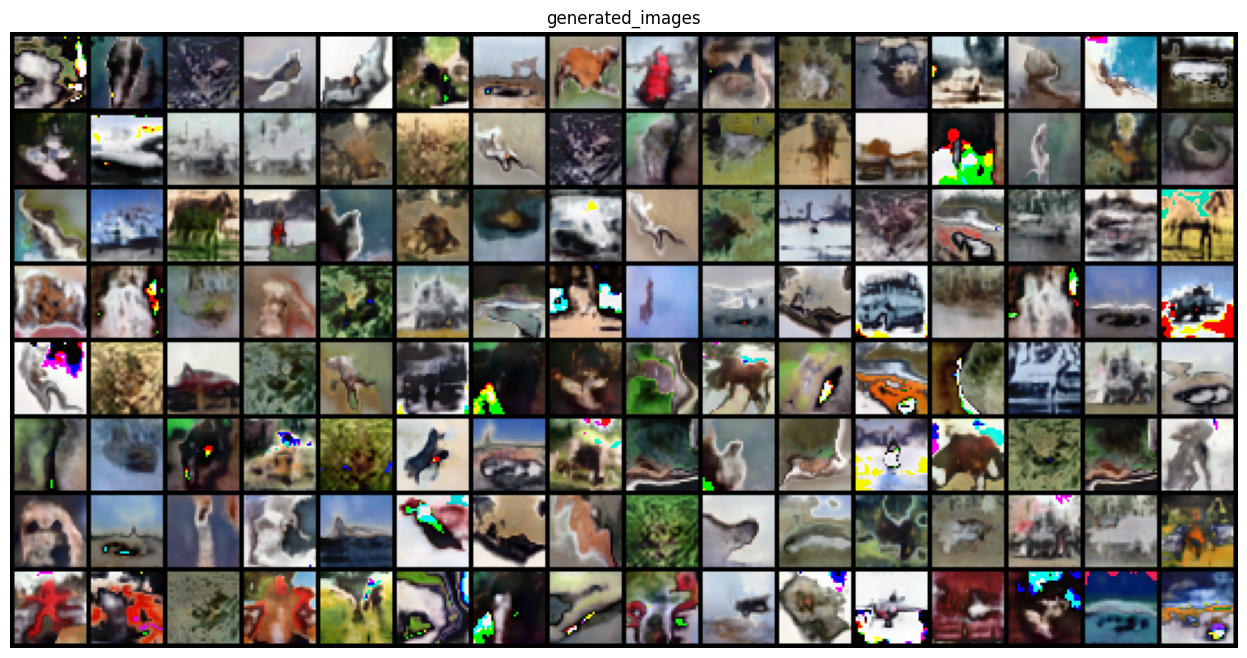

In [ ]:
# Load the pretrained model
number_of_images = 128
number_of_images_in_row = 16
latent_dim = configs.h_dim_w

gen = configs.generator
gen.eval()


if torch.cuda.is_available():
    gen.load_state_dict(torch.load(PRETRAINED_GEN_PATH))
else:
    gen.load_state_dict(torch.load(PRETRAINED_GEN_PATH, map_location=torch.device('cpu')))

    
z = torch.randn(number_of_images, latent_dim).to(configs.device)
imgs_gen = gen(z)

# Plot the generated images
plt.figure(figsize=(16,8))
plt.axis('off')
plt.title(f'generated_images')

img_gen_denorm = transforms.Normalize((-1, -1, -1), (2, 2, 2))(imgs_gen.detach().cpu())  
plt.imshow(make_grid((img_gen_denorm * 255).to(dtype=torch.uint8), nrow=number_of_images_in_row).permute((1, 2, 0)))

## 3.1 Loss Plot
Since we didn't train the model in one-shot, we don't have a full loss plot of the whole training. However, here is a loss plot of training the model from scratch up to 22000 steps. Note that we smooth the loss plot in order to see the trend clearly. Otherwise, the huge jumps in the loss plot distort the scale of the plot and makes the details vanish.

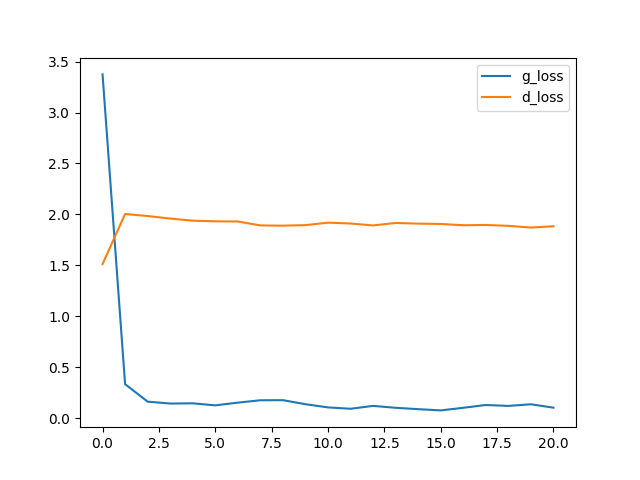

In [ ]:
# Here is the loss plot of the model trained on CIFAR-10 dataset for 20_000 steps
# Note that we don't log the actual loss in every step, rather we take the average loss to have a smoother plot
# Here the loss is logged in every 1_000 steps, so we have 20_000 / 1000 = 20 loss values in this plot.

image = Image.open(os.path.join(ROOT_PATH, "selected_output", "loss_plot_20K_cifar.png"))
display(image)

## 3.2 EVALUATION (CIFAR10)

### 3.2.1 Generate an image dataset 
For evaluation, we compute IS and FID scores of the generated images following the paper's implementation. To this end, we first need to generate an image dataset of 50K images (see the description of Table.2).

In [ ]:
from torchvision.utils import save_image

def generate_dataset(configs, pretrained_model_path, gen_dataset_save_path, stop_at = 5_000):

  # Load the pretrained model
  gen = configs.generator
  gen.eval()
  if torch.cuda.is_available():
    gen.load_state_dict(torch.load(PRETRAINED_GEN_PATH))
  else:
    gen.load_state_dict(torch.load(PRETRAINED_GEN_PATH, map_location=torch.device('cpu')))

  for i in range(stop_at):
    # Generate an image and save it
    z = torch.randn(1, latent_dim).to(configs.device)
    imgs_gen = gen(z).squeeze(dim = 0)                                                  # Generated images are coming from a range [-1,1]
    imgs_gen_denorm = transforms.Normalize((-1, -1, -1), (2, 2, 2))(imgs_gen.detach())  # We normalize the images to a range [0,1]
  
    save_image(imgs_gen_denorm, os.path.join(gen_dataset_save_path, f"styleformer_{i}.jpg")) 

In [ ]:
# Create a generated images dataset (50,000 images takes about 13 mins)
generate_dataset(configs, PRETRAINED_GEN_PATH, GEN_DATASET_SAVE_PATH_CIFAR, stop_at = 50_000)

### 3.2.2 FID Score Calculation

FID score is based on a metric called Frechet Distance. Frechet Distance is a measure between two multivariate distributions. For unimodal normal distributions, it is defined as:

$d(X,Y) = (μ_X - μ_Y)^2 + (σ_X -  σ_Y)^2$

In the multivariate case, we have:

$FD=∣∣μX​−μY​∣∣^2−Tr(∑X​+∑Y​−2\sqrt{∑X​∑Y​})$

where $∑X$ is the covariance matrix of $X$.


To compute FID, we will be using the activations of **Inception V3** model pretrained on ImageNet. 

In [ ]:
# Load the generated dataset for evaluation (this might take some time)
gen_dataset_cifar = generateddataset.GeneratedDataset(img_dir=GEN_DATASET_SAVE_PATH_CIFAR)                  
gen_dataloader_cifar = torch.utils.data.DataLoader(gen_dataset_cifar, batch_size=32, shuffle=True)

# Load the real dataset for evaluation
cifar_10_dataset = CIFAR10(root=DATA_PATH_CIFAR, train=True, download=True, transform=transforms.ToTensor())     # Note: Images are from [0,1] range, for InceptionV3
cifar_dataloader = torch.utils.data.DataLoader(cifar_10_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [ ]:
# Compute FID score over 50K real and fake images
fid_score_cifar = metrics.get_fid_score(configs, cifar_dataloader, gen_dataloader_cifar)
print("FID Score for CIFAR-10: ", fid_score_cifar)
print("Original paper's FID score on CIFAR-10: 2.82")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:04<00:00, 27.1MB/s]


FID Score for CIFAR-10:  55.59796167271156
Original paper's FID score on CIFAR-10: 2.82


### 3.2.3 Inception Score (IS) Calculation

This metric is used to assess the quality of generated images.

In [ ]:
# Compute the Inception Score (IS)
# Note that this computation should be parallel with the Styleformer paper where they state:
# "computing the mean over 10 dependent trials using 5k generated images per trial for IS"
_cuda = torch.cuda.is_available()    
IS_mean, IS_std = metrics.inception_score(gen_dataset_cifar, cuda=_cuda, batch_size=batch_size, resize=True, splits=10)

print("\nCIFAR-10 Pretrained model's Inception Score (IS) on average ", IS_mean, "±", IS_std)
print("\nOriginal paper's IS on CIFAR-10: 10.00 ± 0.12")

Getting predictions:   0%|          | 0/485 [00:00<?, ?it/s]/content/gdrive/MyDrive/group03_version2/metrics/metrics.py:263: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()
IS calculation: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s]



CIFAR-10 Pretrained model's Inception Score (IS) on average  3.4381482098342966 ± 0.06291008012015248

Original paper's IS on CIFAR-10: 10.00 ± 0.12


# 4.0 DEMO - STL10

## 4.0.1 Plot Generated Images

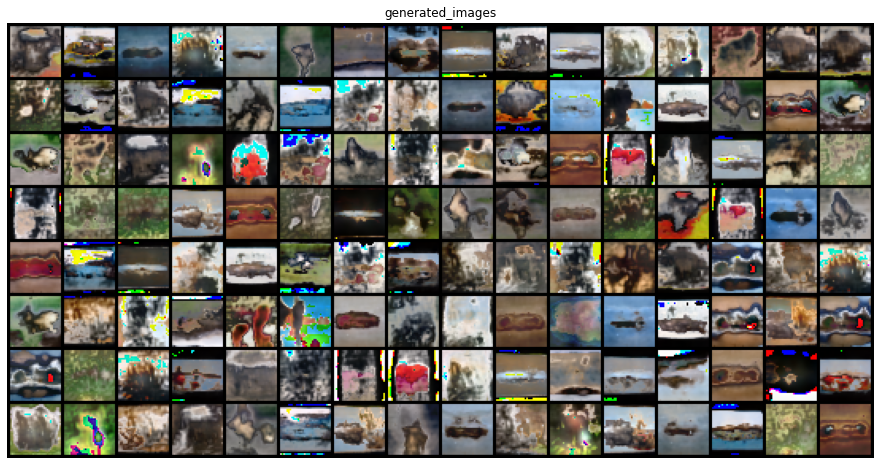

In [ ]:
# Load the pretrained model
number_of_images = 128
number_of_images_in_row = 16
latent_dim = configs.h_dim_w

gen = configs.generator
gen.eval()

if torch.cuda.is_available():
    gen.load_state_dict(torch.load(PRETRAINED_GEN_PATH_STL))
else:
    gen.load_state_dict(torch.load(PRETRAINED_GEN_PATH_STL, map_location=torch.device('cpu')))

z = torch.randn(number_of_images, latent_dim).to(configs.device)
imgs_gen = gen(z)

# Plot the generated images
plt.figure(figsize=(16,8))
plt.axis('off')
plt.title(f'generated_images')
#imgs_gen = imgs_gen.detach().cpu()
img_gen_denorm = transforms.Normalize((-1, -1, -1), (2, 2, 2))(imgs_gen.detach().cpu())  
plt.imshow(make_grid((img_gen_denorm * 255).to(dtype=torch.uint8), nrow=number_of_images_in_row).permute((1, 2, 0)))

## 4.1 Loss Plot
Since we didn't train the model in one-shot, we don't have a full loss plot of the whole training. However, here is a loss plot of training the model from scratch up to 22000 steps. Note that we smooth the loss plot in order to see the trend clearly. Otherwise, the huge jumps in the loss plot distort the scale of the plot and makes the details vanish.

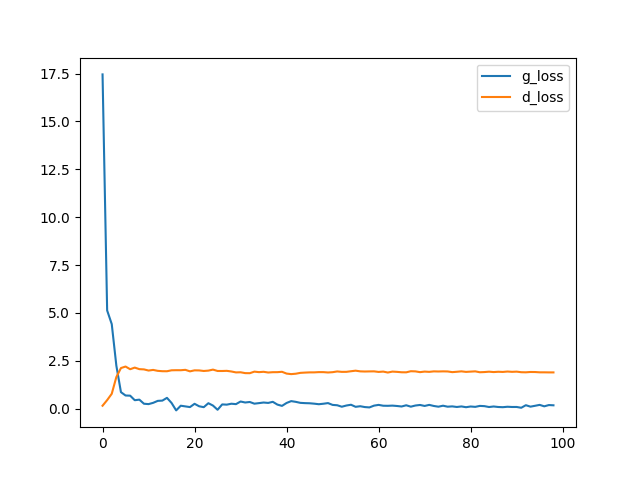

In [ ]:
# Here is the loss plot of the model trained on STL-10 dataset for 10_000 steps
# Note that we don't log the actual loss in every step, rather we take the average loss to have a smoother plot
# Here the loss is logged in every 100 steps, so we have 10_000 / 100 = 100 loss values in this plot.

image = Image.open(os.path.join(ROOT_PATH, "selected_output", "loss_plot_10K_stl.png"))
display(image)

## 4.2 EVALUATION (STL10)

### 4.2.1 Generate an image dataset 
For evaluation, we compute IS and FID scores of the generated images following the paper's implementation. To this end, we first need to generate an image dataset of 50K images (see the description of Table.2).

In [ ]:
# Generating 50K images takes about 13 minutes, for STL-10 we are generating 10K images
generate_dataset(configs, PRETRAINED_GEN_PATH_STL, GEN_DATASET_SAVE_PATH_STL, stop_at = 10_000)

### 4.2.2 FID Score Calculation


In [ ]:
# Load the generated dataset for evaluation (this might take some time)
gen_dataset_stl = generateddataset.GeneratedDataset(img_dir=GEN_DATASET_SAVE_PATH_STL)
gen_dataloader_stl = torch.utils.data.DataLoader(gen_dataset_stl, batch_size=32)

# Load the real dataset for evaluation
transform = transforms.Compose(
                                [transforms.Resize(image_size),
                                transforms.ToTensor()])
stl_10_dataset = STL10(root=DATA_PATH_STL, split="unlabeled", download=True, transform=transform)
stl_dataloader = torch.utils.data.DataLoader(stl_10_dataset, batch_size=32)

Files already downloaded and verified


In [ ]:
# Compute FID score over real and fake images
fid_score_stl = metrics.get_fid_score(configs, stl_dataloader, gen_dataloader_stl)
print("FID Score for STL-10: ", fid_score_stl)
print("Original paper's FID score on STL-10: 15.17")

FID Score for STL-10:  96.8164406379928
Original paper's FID score on STL-10: 15.17


### 4.2.3 Inception Score (IS) Calculation

In [ ]:
# Compute the Inception Score (IS)
# Note that this computation should be parallel with the Styleformer paper where they state:
# "computing the mean over 10 dependent trials using 5k generated images per trial for IS"
_cuda = torch.cuda.is_available()    
IS_mean, IS_std = metrics.inception_score(gen_dataset_stl, cuda=_cuda, batch_size=batch_size, resize=True, splits=10)

print("\nSTL-10 Pretrained model's Inception Score (IS) on average ", IS_mean, " ± ", IS_std)
print("\nOriginal paper's IS on STL-10: 11.01 ± 0.15")

IS calculation: 100%|██████████| 10/10 [00:00<00:00, 14.78it/s]


STL-10 Pretrained model's Inception Score (IS) on average  3.5086587361912507  ±  0.05613910467302634

Original paper's IS on STL-10: 11.01 ± 0.15


# 5.0 Discussion

* We had to change the number of encoders and hidden sizes, as using the values of Table 5 (Layers {1, 3, 3} and Hidden Size {1024,512,512}) gives us CUDA out of memory error. Therefore, we ran the experiments with Layers {1, 2,2} and Hidden Size {256,64,16}

* We have experienced that the training process requires so many iterations (more than 100K) in densely constructed  Styleformer model to get the improvements in the outputs. Therefor,e we switched to Colab's computing units instead of free version, and we used A100 for the training. We supply some extra generated images in a separate folder, see generated_images folder under the outputs folder. You can also check out the plots from different steps.

* Our training was cut off at 22K steps, so we put the results of that checkpoint to the folders "generated_images_22K_steps" and "loss_plot_22K_steps". We then continue the training after that point. It was advised to run at least 150K steps, or 1 day with V100, according to [this blog](https://blog.paperspace.com/how-to-set-up-stylegan2-ada-pytorch-on-paperspace/) and LABML's notes. At our current state, we have trained our model for about 2 hours. The final images at generated_images folder are from 24K to 42K steps (their names are different as we have continued from checkpoint at step 22K).

* Since our training produced results ahead of this notebook's inline results, we provide some additional generated images and plots under the folder "additional_results".


* You can verify that the outputs of this notebook are matching with the images inside, only that folder contains images from further steps that LABML couldn't give us. We used LABML's training procedure as we have taken their StyleGAN2 implementation as our baseline, since Styleformer paper states that they put their model on top of StyleGAN2.

* We observe a decrease in our FID score, we have started from 400s, then dropped 300s, at last we have FID: 288.4, which indicates an improvement but it is far from the paper's result (FID:2.82, IS:10+-0.12). We may expect a huge drop after more training if we have implemented the model correctly. Our latest results (as printed at the cells above) are:

(Version 1, average of many minibatches) Average FID:  288.46

(Version 1) IS score on average  3.23  ±  0.04

* Note that we also observe a decreasing trend as we compute FID with larger batch sizes. Computing FID over 50K images, as Styleformer did, didn't fit to the available RAM. We computed FID with 1024 images for this version.

## 5.1 Assumptions
* Original transformers in language domain (and MIM transformers of image domain) use masks. Paper states that they use the original transformer as closely as possible, but they didn't mention anything about the masks. So we omited the masks as there is no masked pretraining task for Styleformer, as far as we understood. Also, we didn't put dropout layers of transformer or normalization, as there was no indication about them; we have just implemented multi-head self-attention as depicted in fig.2(b)

* In the encoder structure in Figure2-b, demodulation is given before the modified residual operation, but, the paper states the opposite (first residual operation then demodulation). We implemented the code in accordance with the written instructions.

* Styleformer mentions "Originally ToRGB layer converts high-dimensional per pixel data into RGB per pixel data via 1×1 convolution operation, which we replace it to same operation, linear operation"; however, there were no further details. We kept ToRGB layer of StyleGAN2 as is.

## 5.2 Version 2 Updates
* **Addition of STL-10 dataset training & generation:** We have extended our goals by including STL-10 dataset to our experiments. We didn't train the model until convergence, but we provide IS and FID scores on STL-10 dataset in addition to CIFAR-10.
* **Training more:** We have continued to train our model from Version 1, and even though they are not matching the paper's level, we see an improvement over the generated images. For the first time since Version 1, we are able to occasionally see samples from CIFAR-10 classes such as cats, objects resembling to cars, ships or planes, and horses.
* **Improving the FID and IS scores:** We are now able to compute FID over 50K images without running into memory errors. We now have complete implementation of evaluation metrics used in the paper: FID and IS computed from 50K generated images. Compared to Version 1, both of our FID and Inception Score are improved significantly. The improvement on FID score is due to the fact that we are now able to compute mean and variance over 50K images, not 32 (batch_size) images as in Version 1 which gives us more accurate FID score. Inception Score increased as we continue to train our model from 47K steps to **176K steps**. We also trained our model from scratch using STL-10 dataset for **86K steps**.
* **Refactoring the notebook according to the reviwer group's feedback:** We have decluttered the main notebook by moving most of the declarations to their respective source files. The only parts left here are related to training the model and plotting the results.

## 5.3 Final Scores (Comparing with Table.2)
---
CIFAR-10 Pretrained **FID: 55.6** (paper: 2.82, Progressive-GAN: 15.52)

CIFAR-10 Pretrained **IS:  3.44 ± 0.063** (paper: 10.00 ± 0.12,  Progressive-GAN: 8.80 ± 0.05)

STL-10 Pretrained **FID: 96.816** (paper: 15.17, SN-GAN: 40.1)

STL-10 Pretrained **IS: 3.509  ±  0.056** (paper: 11.01 ± 0.15, SN-GAN: 9.16 ± 0.12)